In [1]:
import numpy as np
from matplotlib import cm
from matplotlib import colors
import matplotlib.pyplot as plt
from halotools.sim_manager import CachedHaloCatalog
from halotools.mock_observables import wp
from halotools.empirical_models import PrebuiltHodModelFactory,  Zheng07Cens, Zheng07Sats, TrivialPhaseSpace,NFWPhaseSpace, HodModelFactory
from halotools.mock_observables import return_xyz_formatted_array
from astropy.cosmology import FlatLambdaCDM
from tabcorr import TabCorr
import emcee
import warnings
warnings.filterwarnings("ignore")
import scipy.constants as sc
import scipy.stats as ss
from astropy.table import Table
from scipy.optimize import fsolve
from scipy.interpolate import interp1d


In [2]:
halocat = CachedHaloCatalog(fname = '/Users/lmezini/.astropy/cache/halotools/halo_catalogs/SMDPL/rockstar/smdpl.dat.smdpl2.hdf5',update_cached_fname = True)

In [3]:
G =  4.302*(10**-9.)
mvir = halocat.halo_table['halo_mvir']
rvir = halocat.halo_table['halo_rvir']
hms = halocat.halo_table['halo_halfmass_scale']
vmax = halocat.halo_table['halo_vmax']
vvir = np.sqrt((G*mvir)/rvir)

cnfw = np.linspace(1, 1400,140000)
vmax_interp = np.sqrt(0.2162166 * 1.0/( (np.log(1+cnfw)/cnfw) - (1/(1+cnfw)) ) )
get_c = interp1d(vmax_interp,cnfw,fill_value='extrapolate')
c = get_c(vmax/vvir)

69


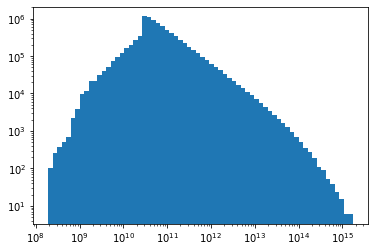

In [4]:
num_bins = abs(int((np.min(np.log10(mvir))-np.max(np.log10(mvir)))*10))
print(num_bins)
bins=np.logspace(np.min(np.log10(mvir)),np.max(np.log10(mvir)),num=num_bins)
plt.hist(mvir,bins=bins)
#plt.ylim(0,2e4)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [5]:
delta = []
mass = []
con = []
for i in range(1,num_bins):
    mask = np.logical_and(mvir>bins[i-1],mvir<bins[i])
    delta.append((c[mask]-np.mean(c[mask]))/np.std(c[mask]))
    mass.append(mvir[mask])
    con.append(c[mask])
mass = np.concatenate(mass)
delta = np.concatenate(delta)[np.argsort(mass)[::-1]]
con = np.concatenate(con)[np.argsort(mass)[::-1]]
mass = mass[np.argsort(mass)[::-1]]

In [702]:
delta2 = []
for i in range(1,50):
    mask = np.logical_and(mvir>bins[i-1],mvir<bins[i])
    delta2.append((hms[mask]-np.mean(hms[mask]))/np.std(hms[mask]))
i = 50
mask = np.where(mvir>bins[i-1])
delta2.append((hms[mask]-np.mean(hms[mask]))/np.std(hms[mask]))

delta2= np.concatenate(delta2)

In [100]:
A = 0.45
combo = mass*10**(A*delta)

In [101]:
np.log10(np.max(combo))

20.188166841621626

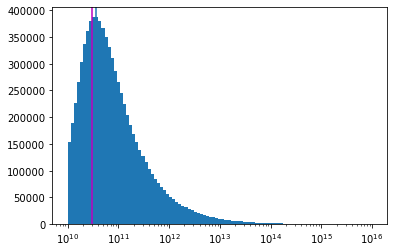

In [102]:
bins = np.logspace(10,16,100)
counts,bins,patches = plt.hist(combo,bins=bins)
plt.axvline(bins[np.where(counts == np.max(counts))],c='m')
plt.xscale('log')
plt.axvline(3.65543638e+10)
#plt.axvline(7.12360779e+10)

In [99]:
np.where(counts == np.max(counts))
(bins[np.where(counts == np.max(counts))[0]+2]+bins[np.where(counts == np.max(counts))[0]]+1)/2


array([3.54543638e+10])

In [19]:
np.where(counts == np.max(counts))[0]-1

array([10])

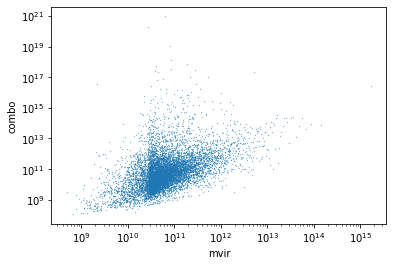

In [662]:
plt.scatter(mvir[0::1000],combo[0::1000],s=0.05)
plt.xlabel('mvir')
plt.ylabel('combo')
plt.xscale('log')
plt.yscale('log')

In [311]:
cnfw = np.linspace(1, 1400,140000)
vmax_interp = np.sqrt(0.2162166 * 1.0/( (np.log(1+cnfw)/cnfw) - (1/(1+cnfw)) ) )

In [312]:
get_c = interp1d(vmax_interp,cnfw,fill_value='extrapolate')

Text(0, 0.5, 'c')

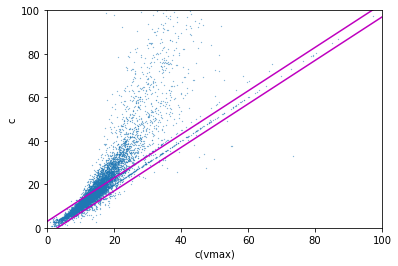

In [318]:
plt.scatter(get_c(vmax/vvir)[0::1000],c[0::1000],s=0.05)
plt.ylim(0,100)
plt.xlim(0,100)
plt.plot((0,100),np.array((0,100))+3,c='m')
plt.plot((0,100),np.array((0,100))-3,c='m')
plt.xlabel('c(vmax)')
plt.ylabel('c')

In [314]:
func = lambda cnfw :np.sqrt(0.2162166 * 1.0/( (np.log(1+cnfw)/cnfw) - (1/(1+cnfw)) ) )

In [328]:
get_c(vmax[4700000]/vvir[4700000]),c[4700000]

(array(6.9898849), 5.961664)

Plot WP

In [12]:
dname = '20'
param = 'pseudo'
threshold=-20
if '21' in dname:
    import zehavi_data_file_21
    wp_ng_vals = zehavi_data_file_21.get_wp()[0:12]
    bin_edges = zehavi_data_file_21.get_bins()[0:12]
    cov_matrix = zehavi_data_file_21.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
elif '19' in dname:
    print('19')
    import zehavi_data_file_19
    wp_ng_vals = zehavi_data_file_19.get_wp()[0:12]
    bin_edges = zehavi_data_file_19.get_bins()[0:12]
    cov_matrix = zehavi_data_file_19.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])    
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
elif '20_noGW' in dname:
    print('20 noGW')
    import zehavi_data_file_20_noGW
    wp_ng_vals = zehavi_data_file_20_noGW.get_wp()[0:12]
    bin_edges = zehavi_data_file_20_noGW.get_bins()[0:12]
    cov_matrix = zehavi_data_file_20_noGW.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])    
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
elif '20' in dname:
    print('20')
    import zehavi_data_file_20
    wp_ng_vals = zehavi_data_file_20.get_wp()[0:12]
    bin_edges = zehavi_data_file_20.get_bins()[0:12]
    cov_matrix = zehavi_data_file_20.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])    
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
elif 'guo' in dname:
    wp_ng_vals = guo_data_file.get_wp()
    bin_edges = guo_data_file.get_bins()
    cov_matrix = guo_data_file.get_cov()
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
elif 'mock' in dname:
    wp_ng_vals = mock_data_2.get_wp()
    bin_edges = mock_data_2.get_bin_edges()
    cov_matrix = mock_data_2.get_cov()
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.

20


In [13]:
a = -0.0506208

combo = np.array(mass*10**(a*delta))
halocat.halo_table['pseudo']=combo

cens_occ_model = Zheng07Cens(prim_haloprop_key = 'pseudo',threshold=threshold)
cens_prof_model = TrivialPhaseSpace()

sats_occ_model =  Zheng07Sats(prim_haloprop_key = 'pseudo',
    modulate_with_cenocc=True,threshold=threshold)
sats_prof_model = NFWPhaseSpace()

model_instance = HodModelFactory(centrals_occupation = cens_occ_model, centrals_profile = cens_prof_model, satellites_occupation = sats_occ_model, satellites_profile = sats_prof_model)

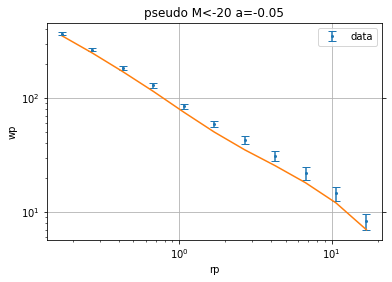

In [14]:
plt.errorbar(bin_cen,wp_ng_vals[1:len(wp_ng_vals)],yerr=np.sqrt(err),fmt='o',markersize=2,capsize=4,label='data')
a = round(a,2)
halocat.redshift = 0.
pi_max = 60.
Lbox = 400.
halotab = TabCorr.read('/Users/lmezini/Halo/tabcorr_tables_pseudo/smdpl_pseudo_a{}.hdf5'.format(a))

param_sampling = [[-0.0506208, 11.89313993, 0.02309876, 1.01328487, 12.31168174, 13.18507731]]
for i in range(1):

    model_instance.param_dict['logMmin'] = param_sampling[i][1]#Mmin_val[i]
    model_instance.param_dict['sigma_logM'] = param_sampling[i][2]#sigma_val[i]
    model_instance.param_dict['alpha'] = param_sampling[i][3]#alpha_val[i]
    model_instance.param_dict['logM0'] = param_sampling[i][4]#M0_val[i]
    model_instance.param_dict['logM1'] = param_sampling[i][5]#M1_val[i]
   
    ngal, wp_calc = halotab.predict(model_instance)
    plt.plot(bin_cen,wp_calc,markersize=2)#,label='Vmax')
#plt.plot(bin_cen,oldfunc,label='Old Corrfunc')
#plt.title("")
plt.legend()
plt.ylabel('wp')
plt.xlabel('rp')
plt.tick_params(right=True)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.title("{} M<{} a={}".format(param,threshold,a))
plt.savefig("wp{}M{}a{}.png".format(param,threshold,a))